# Mask R-CNN for Keypoint Detection

Example showing how to do keypoint detection with Mask R-CNN

In [7]:
USE_GPU = True
TRAIN   = True

%matplotlib inline
import importlib
import os

if not USE_GPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import imgaug
import time

# Root directory of the project
ROOT_DIR = os.path.abspath(".")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Load COCO Datasets for Keypoint Detection

In [8]:
from coco import coco_keypoints
importlib.reload(coco_keypoints)

# COCO dataset dir
COCO_DATA_DIR = "A:/Programming/DeepLearningDatasets/coco" if os.path.isdir("A:/Programming/DeepLearningDatasets/coco") else os.path.join(ROOT_DIR, "data/coco")

# Prepare dataset
#keypoints_to_include = ['nose', 'left_shoulder', 'right_shoulder',
#                        'left_elbow', 'right_elbow', 'left_wrist',
#                        'right_wrist', 'left_hip', 'right_hip',
#                        'left_knee', 'right_knee', 'left_ankle',
#                        'right_ankle']
keypoints_to_include = ["nose", "right_wrist"]

dataset_train = coco_keypoints.CocoDataset()
dataset_train.load_coco(COCO_DATA_DIR, subset="train", year="2017", auto_download=True, keypoints_to_include=keypoints_to_include)
dataset_train.prepare()

dataset_val = coco_keypoints.CocoDataset()
dataset_val.load_coco(COCO_DATA_DIR, subset="val", year="2017", auto_download=True, keypoints_to_include=keypoints_to_include)
dataset_val.prepare()

Will use images in /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017
Will use annotations in /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/annotations/person_keypoints_train2017.json
loading annotations into memory...
Done (t=8.28s)
creating index...
index created!
Will use images in /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017
Will use annotations in /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/annotations/person_keypoints_val2017.json
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


### Setup Training

In [3]:
class TrainConfig(Config):
    NAME = "coco_keypoints"
    
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1 # IMAGES_PER_GPU = 2
    GPU_COUNT = 1
    
    # We use resnet50
    BACKBONE = "resnet50"
    
    # Set number of classes
    NUM_CLASSES = dataset_train.num_classes
    NUM_KEYPOINTS = dataset_train.num_kp_classes
    
    # DEBUG:
    STEPS_PER_EPOCH = 100 if USE_GPU else 10
    
    TRAIN_ROIS_PER_IMAGE = 100
    #MAX_GT_INSTANCES = 1
    
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

config = TrainConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
NAM

## Train

In [4]:
if TRAIN:
    importlib.reload(modellib)

    # Create model
    print("Creating model...")
    model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=config)

    # Load weights trained on MS-COCO
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
                       #exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_mask"])

Creating model...

build:
input_gt_boxes.shape (?, ?, 4)
input_gt_kp_ids.shape (?, ?, 2)
input_gt_masks.shape (?, ?, 2)
gt_masks.shape (?, 2)
masks.shape (?, 2)
kps_1d_indices.shape (?,)
kps_x.shape (?, ?)
kps_x.shape (?, ?)
resized_kps_x.shape (?, ?)
kps_indices.shape (?, ?)
masks.shape (?, ?)
target_mask.shape (1, ?, ?)
target_mask.dtype <dtype: 'int32'>
mrcnn_mask.shape (?, 100, 2, 28, 28)

mrcnn_mask_loss_graph shapes:
target_masks.shape (1, ?, ?)
target_masks.dtype <dtype: 'int32'>
target_kp_ids.shape (1, ?, ?)
pred_masks.shape (?, 100, 2, 28, 28)
y_true.shape (?,)
y_pred.shape (?, ?)


mrcnn_mask_loss_graph shapes:
target_masks.shape (?, 100, 2)
target_masks.dtype <dtype: 'int32'>
target_kp_ids.shape (?, 2)
pred_masks.shape (?, 100, 2, 28, 28)
y_true.shape (?,)
y_pred.shape (?, ?)



In [5]:
if TRAIN:
    importlib.reload(modellib)
    
    train_start_time = time.time()
    
    # Training - Stage 1
    print("Training network heads...")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=4,
                layers="heads",
                augmentation=None)
    
    elapsed_time = time.time() - train_start_time
    print("Elapsed time %im %is" % (elapsed_time // 60, elapsed_time % 60))

Training network heads...

Starting at epoch 0. LR=0.001

Checkpoint Path: /datasets/home/78/378/cs252cas/Pose_RCNN/logs/coco_keypoints20180602T1551/mask_rcnn_coco_keypoints_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_mask_conv4       (TimeDis

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/4
 630/1000 [=================>............] - ETA: 1:06 - loss: 4.6508 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 0.7904 - mrcnn_bbox_loss: 0.4757 - mrcnn_mask_loss: 3.3352

ERROR:root:Error processing image {'id': 46847, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000046847.jpg', 'width': 640, 'height': 335, 'annotations': [{'segmentation': [[545.16, 92.36, 547.03, 91.68, 549.92, 95.42, 552.3, 97.97, 553.66, 100.18, 550.94, 101.88, 544.82, 103.24, 542.78, 101.88, 543.8, 96.44, 544.99, 91.34]], 'num_keypoints': 0, 'area': 75.8914, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 46847, 'bbox': [542.78, 91.34, 10.88, 11.9], 'category_id': 1, 'id': 205804}, {'segmentation': [[543.47, 90.79, 543.92, 91.68, 544.22, 93.76, 544.36, 94.5, 543.03, 101.47, 544.36, 103.25, 544.66, 103.7, 544.51, 112.01, 542.29, 112.45, 541.25, 111.12, 540.95, 110.97, 542.29, 102.66, 541.1, 102.81, 540.51, 112.3, 537.98, 111.56, 537.39, 103.11, 537.84, 100.88, 537.39, 98.8, 537.39, 97.47, 537.84

Exception: INFO: Image with ID 25782 produced erroneus bbox x1 == x2


 999/1000 [============================>.] - ETA: 0s - loss: 4.4509 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 0.7691 - mrcnn_bbox_loss: 0.4479 - mrcnn_mask_loss: 3.1847

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:2251: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
ERROR:root:Error processing image {'id': 384666, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000384666.jpg', 'width': 500, 'height': 332, 'annotations': [{'segmentation': [[172.51, 190.23, 177.71, 183.41, 181.6, 177.89, 184.85, 172.04, 187.12, 165.54, 189.72, 164.57, 194.27, 160.02, 198.49, 157.75, 200.76, 154.18, 200.11, 146.06, 200.76, 140.86, 205.63, 138.27, 210.83, 137.29, 217.98, 142.49, 217.98, 150.28, 216.03, 155.8, 218.3, 159.05, 220.25, 166.19, 223.17, 173.99, 225.44, 180.16, 228.04, 187.63, 229.67, 192.5, 235.19, 192.82, 235.84, 196.4, 234.54, 202.57, 232.26, 202.57, 226.74, 196.72, 223.5, 193.15, 217.33, 191.2, 217.33, 193.15, 219.92, 19

Exception: INFO: Image with ID 2566 produced erroneus bbox x1 == x2
ERROR:root:Error processing image {'id': 290179, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000290179.jpg', 'width': 640, 'height': 426, 'annotations': [{'segmentation': [[157.78, 329.94, 157.61, 327.78, 158.04, 326.92, 158.65, 328.22, 158.99, 329.34, 158.3, 330.37]], 'num_keypoints': 0, 'area': 2.82335, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 290179, 'bbox': [157.61, 326.92, 1.38, 3.45], 'category_id': 1, 'id': 1740577}, {'segmentation': [[154.4, 330.8, 155.29, 328.81, 155.95, 330.14, 155.29, 332.13, 154.4, 332.68, 154.4, 332.02]], 'num_keypoints': 0, 'area': 3.4096, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

1000/1000 [==============================] - 207s 207ms/step - loss: 4.4541 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 0.7690 - mrcnn_bbox_loss: 0.4478 - mrcnn_mask_loss: 3.1881 - val_loss: 4.0390 - val_rpn_class_loss: 0.0334 - val_rpn_bbox_loss: 0.6527 - val_mrcnn_bbox_loss: 0.3316 - val_mrcnn_mask_loss: 3.0214
Epoch 2/4
   3/1000 [..............................] - ETA: 2:58 - loss: 5.2823 - rpn_class_loss: 0.0445 - rpn_bbox_loss: 0.6330 - mrcnn_bbox_loss: 0.2361 - mrcnn_mask_loss: 4.3687

ERROR:root:Error processing image {'id': 263760, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000263760.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[499.46, 146.49, 515.68, 163.78, 517.84, 187.57, 524.32, 234.05, 534.05, 262.16, 541.62, 275.14, 539.46, 290.27, 530.81, 303.24, 532.97, 316.22, 534.05, 324.86, 523.24, 360.54, 508.11, 370.27, 490.81, 377.84, 472.43, 382.16, 450.81, 381.08, 425.95, 368.11, 402.16, 354.05, 387.03, 344.32, 362.16, 320.54, 347.03, 306.49, 326.49, 322.7, 315.68, 335.68, 301.62, 349.73, 294.05, 360.54, 281.08, 370.27, 265.95, 375.68, 254.05, 374.59, 243.24, 368.11, 236.76, 368.11, 228.11, 370.27, 214.05, 373.51, 201.08, 368.11, 191.35, 360.54, 164.32, 336.76, 160, 316.22, 160, 301.08, 174.05, 295.68, 194.59, 300, 211.89, 312.97, 229.19, 318.38, 233.51, 311.89, 229.19, 298.92, 225.95, 280.54, 227.03, 267.57, 235.68, 255.68, 245.41, 253.51, 260.54, 262.16, 273.51, 267.57, 286.49, 264.32, 278.92

Exception: INFO: Image with ID 890 produced erroneus bbox x1 == x2


  71/1000 [=>............................] - ETA: 2:38 - loss: 4.0667 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 0.6846 - mrcnn_bbox_loss: 0.3647 - mrcnn_mask_loss: 2.9765

ERROR:root:Error processing image {'id': 166424, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000166424.jpg', 'width': 640, 'height': 482, 'annotations': [{'segmentation': [[225.41, 320.68, 227.65, 317.17, 231.17, 317.81, 239.49, 322.12, 242.68, 327.08, 244.6, 332.36, 244.28, 336.83, 241.24, 341.95, 240.92, 348.67, 244.76, 354.26, 251.32, 361.46, 253.88, 367.21, 257.23, 371.85, 261.71, 378.89, 264.75, 385.44, 264.91, 392.96, 262.83, 398.87, 259.31, 401.75, 254.84, 402.87, 254.04, 404.63, 254.2, 412.31, 254.84, 422.22, 253.08, 426.86, 253.88, 432.29, 255.95, 440.13, 256.27, 441.89, 255.32, 443.49, 255.32, 459.32, 251.96, 466.35, 251.64, 473.07, 251.16, 476.43, 249.24, 482, 207.19, 482, 206.87, 474.19, 209.26, 466.99, 213.74, 461.08, 214.54, 455.16, 211.02, 444.45, 212.78, 439.49, 212.78, 426.22, 208.14, 421.74, 210.06, 415.18, 210.54, 406.55, 209.74, 397.44, 208.14, 387.04, 207.99, 381.45, 205.27, 376.97, 206.39, 363.38, 209.1, 356.5, 212.62

Exception: INFO: Image with ID 19474 produced erroneus bbox x1 == x2


1000/1000 [==============================] - 193s 193ms/step - loss: 4.1383 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 0.7520 - mrcnn_bbox_loss: 0.3631 - mrcnn_mask_loss: 2.9805 - val_loss: 4.2059 - val_rpn_class_loss: 0.0441 - val_rpn_bbox_loss: 0.7703 - val_mrcnn_bbox_loss: 0.3404 - val_mrcnn_mask_loss: 3.0512
Epoch 3/4
 184/1000 [====>.........................] - ETA: 2:22 - loss: 3.9495 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.6259 - mrcnn_bbox_loss: 0.3322 - mrcnn_mask_loss: 2.9545

ERROR:root:Error processing image {'id': 438629, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000438629.jpg', 'width': 640, 'height': 640, 'annotations': [{'segmentation': [[475.04, 485.55, 475.04, 474.52, 471.03, 473.26, 472.29, 465.99, 472.29, 460.73, 475.8, 458.22, 476.05, 456.21, 476.8, 453.96, 479.56, 453.96, 480.06, 455.71, 479.06, 457.72, 478.55, 458.72, 478.3, 459.98, 481.56, 461.23, 482.32, 463.24, 482.32, 466.24, 482.32, 466.24, 481.16, 469.07, 480.9, 470.18, 482.09, 471.28, 482.52, 472.73, 482.52, 474.34, 481.24, 474.68, 479.2, 474.26, 478.35, 474.51, 479.73, 479.96, 479.51, 485.05, 481.21, 485.69, 479.51, 486.33, 477.82, 486.12, 475.91, 486.12, 473.78, 486.12, 474.88, 485.83]], 'num_keypoints': 0, 'area': 214.2106, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 438629, 'bbox': [471.03

 914/1000 [==========================>...] - ETA: 14s - loss: 3.9455 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 0.7061 - mrcnn_bbox_loss: 0.3528 - mrcnn_mask_loss: 2.8440

ERROR:root:Error processing image {'id': 458309, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000458309.jpg', 'width': 612, 'height': 612, 'annotations': [{'segmentation': [[385.66, 38.43, 387.16, 37.28, 387.6, 38.25, 388.13, 39.84, 388.04, 41.61, 388.04, 41.61, 389.28, 41.88, 389.23, 46.83, 388.37, 48.43, 389.23, 49.29, 389.11, 49.29, 388.25, 56.01, 388.74, 59.59, 388.74, 61.8, 387.26, 62.42, 385.29, 61.8, 384.78, 59.22, 384.78, 54.94, 384.68, 52.96, 385.93, 44.69, 385.51, 42.29, 385.72, 40.83, 385.72, 39.37, 385.72, 38.54]], 'num_keypoints': 0, 'area': 83.1909, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 458309, 'bbox': [384.68, 37.28, 4.6, 25.14], 'category_id': 1, 'id': 443646}, {'segmentation': [[133.84, 37.93, 135.64, 38.19, 136.54, 39.86, 136.54, 40.38, 139.63, 42.69, 140.65, 45.77, 140

 919/1000 [==========================>...] - ETA: 13s - loss: 3.9493 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 0.7046 - mrcnn_bbox_loss: 0.3524 - mrcnn_mask_loss: 2.8497

ERROR:root:Error processing image {'id': 241025, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000241025.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[166.34, 352.5, 165.46, 349.99, 165.46, 348.07, 165.9, 344.23, 166.34, 341.72, 167.38, 339.21, 167.82, 337.88, 169.44, 335.81, 170.92, 334.63, 172.55, 335.07, 173.14, 336.55, 172.25, 338.77, 171.22, 339.21, 171.66, 340.69, 171.07, 345.71, 172.84, 344.82, 172.84, 345.56, 171.95, 348.66, 171.36, 350.43, 170.48, 349.84, 168.12, 349.4, 167.97, 350.43, 166.64, 351.91]], 'num_keypoints': 0, 'area': 82.14365, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 241025, 'bbox': [165.46, 334.63, 7.68, 17.87], 'category_id': 1, 'id': 1268708}, {'segmentation': [[215.58, 341.19, 216.31, 335.58, 216.31, 329.97, 218.27, 327.78, 218.27, 324.86, 2

Exception: INFO: Image with ID 54969 produced erroneus bbox x1 == x2


 999/1000 [============================>.] - ETA: 0s - loss: 3.9430 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 0.7030 - mrcnn_bbox_loss: 0.3510 - mrcnn_mask_loss: 2.8463

ERROR:root:Error processing image {'id': 308587, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000308587.jpg', 'width': 480, 'height': 640, 'annotations': [{'segmentation': [[114.29, 372.06, 113.25, 370.78, 114.67, 368.58, 115.83, 368.33, 116.48, 369.74, 117.12, 371.16, 116.09, 372.06, 116.35, 373.87, 119.44, 371.94, 120.34, 371.81, 120.6, 373.22, 118.8, 375.93, 116.22, 376.06, 116.99, 379.67, 120.34, 382.38, 120.22, 383.54, 117.89, 384.57, 113.13, 382.25, 112.35, 377.22, 113.13, 373.48]], 'num_keypoints': 0, 'area': 72.68655, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 308587, 'bbox': [112.35, 368.33, 8.25, 16.24], 'category_id': 1, 'id': 485094}, {'segmentation': [[363.48, 342.29, 364.2, 344.07, 365.26, 344.3, 365.38, 353.67, 364.32, 353.32, 364.32, 351.42, 362.18, 348.93, 361.82, 347.63, 363.0

1000/1000 [==============================] - 192s 192ms/step - loss: 3.9409 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 0.7035 - mrcnn_bbox_loss: 0.3511 - mrcnn_mask_loss: 2.8435 - val_loss: 3.7222 - val_rpn_class_loss: 0.0467 - val_rpn_bbox_loss: 0.6726 - val_mrcnn_bbox_loss: 0.3554 - val_mrcnn_mask_loss: 2.6475
Epoch 4/4
 182/1000 [====>.........................] - ETA: 2:20 - loss: 3.9618 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.6914 - mrcnn_bbox_loss: 0.3144 - mrcnn_mask_loss: 2.9203

ERROR:root:Error processing image {'id': 520808, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000520808.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[418, 426.15, 418, 420.45, 418.76, 418.55, 419.14, 415.7, 418.76, 413.04, 417.43, 409.24, 414.58, 410.57, 414.77, 417.22, 413.25, 421.4, 414.01, 425.77, 415.72, 426.9]], 'num_keypoints': 0, 'area': 69.54475, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 520808, 'bbox': [413.25, 409.24, 5.89, 17.66], 'category_id': 1, 'id': 1240548}, {'segmentation': [[406.57, 426.06, 405.48, 424.43, 404.76, 423.16, 404.58, 421.89, 404.58, 421.53, 404.94, 419.36, 404.94, 418.27, 404.94, 417.72, 404.76, 417.36, 404.58, 415.19, 404.58, 414.28, 402.76, 415.19, 401.86, 416.82, 400.95, 418.27, 400.77, 419.54, 400.77, 421.35, 401.13, 421.89, 400.95,

 265/1000 [======>.......................] - ETA: 2:03 - loss: 4.1518 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.7194 - mrcnn_bbox_loss: 0.3207 - mrcnn_mask_loss: 3.0738

ERROR:root:Error processing image {'id': 459659, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000459659.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[349.49, 196.25, 365.32, 191.25, 372.41, 187.91, 372.41, 184.16, 369.07, 185.83, 362.41, 185.83, 364.91, 171.24, 365.32, 154.57, 366.57, 146.24, 376.16, 135.82, 391.16, 131.65, 402.83, 137.07, 411.58, 153.32, 413.25, 160.83, 411.58, 168.74, 409.08, 176.24, 410.75, 183.75, 412.41, 188.75, 409.91, 190.83, 426.17, 195.41, 433.25, 202.92, 435.34, 212.92, 435.75, 221.25, 435.34, 223.75, 421.17, 219.58, 400.75, 224.59, 386.16, 236.67, 385.74, 243.75, 386.58, 247.09, 375.33, 239.59, 365.74, 235.84, 370.33, 227.5, 370.74, 222.92, 359.91, 221.67, 352.41, 220.83, 346.57, 220.83, 339.9, 221.67, 336.15, 217.92, 338.24, 212.5, 344.07, 202.92]], 'num_keypoints': 9, 'area': 5583.62165, 'iscrowd': 0, 'keypoints': [377, 165, 2, 388, 159, 2, 372, 159, 2, 0, 0, 0, 0, 0, 0, 423, 201, 2, 353

IndexError: index 256 is out of bounds for axis 1 with size 256


 999/1000 [============================>.] - ETA: 0s - loss: 4.0333 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 0.7253 - mrcnn_bbox_loss: 0.3388 - mrcnn_mask_loss: 2.9276

ERROR:root:Error processing image {'id': 421060, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000421060.jpg', 'width': 640, 'height': 418, 'annotations': [{'segmentation': [[139.61, 259.01, 155.1, 252.27, 182.71, 209.84, 168.56, 216.58, 167.89, 204.45, 175.97, 197.05, 192.81, 181.56, 217.05, 172.8, 249.38, 163.37, 256.12, 149.9, 268.91, 149.9, 279.69, 157.98, 281.04, 165.39, 274.97, 177.51, 289.12, 194.35, 291.81, 222.64, 283.73, 250.92, 261.5, 272.47, 246.69, 267.09, 252.75, 254.29, 243.32, 261.03, 229.18, 262.37, 215.71, 248.9, 210.99, 261.7, 204.93, 271.8, 192.81, 275.17, 177.32, 263.72, 177.32, 277.19]], 'num_keypoints': 12, 'area': 11417.7497, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 243, 172, 2, 285, 202, 2, 203, 186, 2, 279, 238, 2, 180, 201, 2, 261, 258, 2, 219, 224, 2, 237, 244, 2, 190, 217, 2, 209, 240, 2, 163, 259, 2, 195, 261, 2], 'image_id': 421060, 'bbox': [139.61, 149.9, 152.2, 127.29], 'category

Exception: INFO: Image with ID 1078 produced erroneus bbox x1 == x2


1000/1000 [==============================] - 198s 198ms/step - loss: 4.0368 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 0.7250 - mrcnn_bbox_loss: 0.3389 - mrcnn_mask_loss: 2.9314 - val_loss: 4.6261 - val_rpn_class_loss: 0.0396 - val_rpn_bbox_loss: 0.7025 - val_mrcnn_bbox_loss: 0.3733 - val_mrcnn_mask_loss: 3.5108
Elaped time 13m 29s


In [6]:
if TRAIN:
    importlib.reload(modellib)

    # Training - Stage 2
    # Finetune layers from ResNet stage 4 and up
    print("Fine tune Resnet stage 4 and up...")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=12,
                layers="4+",
                augmentation=None)
    
    elapsed_time = time.time() - train_start_time
    print("Elapsed time %im %is" % (elapsed_time // 60, elapsed_time % 60))

Fine tune Resnet stage 4 and up...

Starting at epoch 4. LR=0.001

Checkpoint Path: /datasets/home/78/378/cs252cas/Pose_RCNN/logs/coco_keypoints20180602T1551/mask_rcnn_coco_keypoints_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_br

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 5/12
 463/1000 [============>.................] - ETA: 1:58 - loss: 4.2708 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 0.7227 - mrcnn_bbox_loss: 0.3276 - mrcnn_mask_loss: 3.1784

ERROR:root:Error processing image {'id': 208028, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000208028.jpg', 'width': 640, 'height': 428, 'annotations': [{'segmentation': [[579.96, 378.84, 564.58, 378.84, 530.91, 378.84, 500.13, 373.07, 488.59, 364.41, 470.32, 355.75, 453.97, 334.59, 451.08, 326.9, 451.08, 314.4, 448.2, 295.16, 459.74, 293.24, 474.17, 293.24, 502.06, 302.85, 534.76, 309.59, 557.84, 309.59, 562.65, 309.59, 569.38, 298.05, 563.61, 273.04, 549.19, 251.88, 512.64, 249.96, 446.27, 238.41, 420.31, 238.41, 409.73, 238.41, 352.98, 231.68, 332.78, 222.06, 333.74, 206.67, 337.59, 203.79, 343.36, 201.87, 435.69, 193.21, 456.85, 188.4, 486.67, 188.4, 497.25, 189.36, 499.17, 185.51, 498.21, 170.13, 480.9, 167.24, 464.55, 158.58, 440.5, 151.85, 417.42, 144.16, 382.8, 148, 375.1, 140.31, 375.1, 131.65, 382.8, 120.11, 392.41, 114.34, 426.08, 113.38, 434.73, 113.38, 453.97, 116.27, 479.94, 127.81, 479.94, 127.81, 486.67, 128.77, 508.79, 13

 911/1000 [==========================>...] - ETA: 19s - loss: 4.1628 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 0.7225 - mrcnn_bbox_loss: 0.3274 - mrcnn_mask_loss: 3.0715

ERROR:root:Error processing image {'id': 560009, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000560009.jpg', 'width': 640, 'height': 501, 'annotations': [{'segmentation': [[248.24, 214.96, 248.24, 204.8, 239.22, 193.52, 233.57, 178.85, 230.19, 161.92, 236.96, 147.25, 251.63, 137.1, 283.22, 133.71, 296.76, 145, 303.53, 167.56, 302.41, 177.72, 303.53, 184.49, 306.92, 196.9, 302.41, 216.08, 293.38, 225.11, 319.33, 229.63, 354.31, 242.04, 364.47, 274.76, 371.24, 317.64, 385.91, 415.81, 387.03, 441.76, 205.04, 442.41, 183.81, 442.41, 176.96, 416.37, 191.34, 372.53, 187.92, 318.41, 181.07, 304.71, 179.01, 289.64, 187.23, 259.5, 191.34, 249.23, 229.7, 231.41, 246.14, 219.77]], 'num_keypoints': 12, 'area': 45054.69995, 'iscrowd': 0, 'keypoints': [296, 183, 2, 297, 172, 2, 284, 175, 2, 0, 0, 0, 251, 191, 2, 335, 250, 2, 215, 263, 2, 361, 340, 2, 181, 344, 1, 375, 416, 2, 163, 430, 1, 336, 444, 1, 246, 453, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'i

IndexError: index 256 is out of bounds for axis 1 with size 256


 999/1000 [============================>.] - ETA: 0s - loss: 4.1469 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 0.7276 - mrcnn_bbox_loss: 0.3274 - mrcnn_mask_loss: 3.0506

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:2251: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 239s 239ms/step - loss: 4.1431 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 0.7269 - mrcnn_bbox_loss: 0.3274 - mrcnn_mask_loss: 3.0476 - val_loss: 3.7290 - val_rpn_class_loss: 0.0386 - val_rpn_bbox_loss: 0.6677 - val_mrcnn_bbox_loss: 0.3159 - val_mrcnn_mask_loss: 2.7067
Epoch 6/12
 198/1000 [====>.........................] - ETA: 2:47 - loss: 4.1148 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.6290 - mrcnn_bbox_loss: 0.3220 - mrcnn_mask_loss: 3.1260

ERROR:root:Error processing image {'id': 469195, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000469195.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[485.7, 235.79, 485.62, 233.13, 485.97, 231.53, 486.33, 230.11, 486.95, 227.98, 488.99, 228.25, 489.88, 229.76, 489.88, 231.8, 489.88, 233.13, 489.52, 234.73, 489.79, 236.42, 489.7, 237.04, 488.1, 237.21, 486.33, 236.86]], 'num_keypoints': 0, 'area': 32.9211, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 469195, 'bbox': [485.62, 227.98, 4.26, 9.23], 'category_id': 1, 'id': 556646}, {'segmentation': [[500.62, 232.08, 499.56, 230.22, 500.36, 230.31, 501.24, 230.49, 501.86, 231.11, 501.86, 232.08, 502.22, 233.41, 502.22, 235.45, 502.22, 236.51, 502.22, 236.78, 500, 236.6, 499.03, 235.54, 499.03, 234.03, 499.74, 232.61]], 'num_ke

Exception: INFO: Image with ID 40032 produced erroneus bbox x1 == x2


 999/1000 [============================>.] - ETA: 0s - loss: 4.0488 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.6556 - mrcnn_bbox_loss: 0.3059 - mrcnn_mask_loss: 3.0500

ERROR:root:Error processing image {'id': 421060, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000421060.jpg', 'width': 640, 'height': 418, 'annotations': [{'segmentation': [[139.61, 259.01, 155.1, 252.27, 182.71, 209.84, 168.56, 216.58, 167.89, 204.45, 175.97, 197.05, 192.81, 181.56, 217.05, 172.8, 249.38, 163.37, 256.12, 149.9, 268.91, 149.9, 279.69, 157.98, 281.04, 165.39, 274.97, 177.51, 289.12, 194.35, 291.81, 222.64, 283.73, 250.92, 261.5, 272.47, 246.69, 267.09, 252.75, 254.29, 243.32, 261.03, 229.18, 262.37, 215.71, 248.9, 210.99, 261.7, 204.93, 271.8, 192.81, 275.17, 177.32, 263.72, 177.32, 277.19]], 'num_keypoints': 12, 'area': 11417.7497, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 243, 172, 2, 285, 202, 2, 203, 186, 2, 279, 238, 2, 180, 201, 2, 261, 258, 2, 219, 224, 2, 237, 244, 2, 190, 217, 2, 209, 240, 2, 163, 259, 2, 195, 261, 2], 'image_id': 421060, 'bbox': [139.61, 149.9, 152.2, 127.29], 'category

Exception: INFO: Image with ID 1078 produced erroneus bbox x1 == x2


1000/1000 [==============================] - 233s 233ms/step - loss: 4.0524 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.6554 - mrcnn_bbox_loss: 0.3060 - mrcnn_mask_loss: 3.0536 - val_loss: 4.1539 - val_rpn_class_loss: 0.0347 - val_rpn_bbox_loss: 0.7551 - val_mrcnn_bbox_loss: 0.3809 - val_mrcnn_mask_loss: 2.9833
Epoch 7/12
 307/1000 [========>.....................] - ETA: 2:24 - loss: 4.0831 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.7353 - mrcnn_bbox_loss: 0.3265 - mrcnn_mask_loss: 2.9821

ERROR:root:Error processing image {'id': 259249, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000259249.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[218.93, 166.3, 218.11, 170.67, 223.3, 187.58, 224.66, 198.22, 228.48, 198.76, 228.21, 187.31, 233.66, 190.58, 234.76, 197.4, 238.85, 193.85, 237.48, 187.58, 232.3, 175.85, 232.57, 165.48, 232.3, 164.66, 227.94, 163.3, 228.48, 156.75, 224.66, 155.66, 220.57, 160.03, 221.66, 163.3]], 'num_keypoints': 0, 'area': 457.6327, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 259249, 'bbox': [218.11, 155.66, 20.74, 43.1], 'category_id': 1, 'id': 213136}, {'segmentation': [[51.79, 173.99, 52.37, 172.45, 51.79, 170.42, 49.47, 170.42, 49.47, 172.35, 50.63, 173.51, 51.59, 174.19]], 'num_keypoints': 0, 'area': 7.9737, 'iscrowd': 0, 'keypoint

 823/1000 [=======================>......] - ETA: 36s - loss: 4.2004 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.6993 - mrcnn_bbox_loss: 0.3145 - mrcnn_mask_loss: 3.1494

ERROR:root:Error processing image {'id': 166424, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000166424.jpg', 'width': 640, 'height': 482, 'annotations': [{'segmentation': [[225.41, 320.68, 227.65, 317.17, 231.17, 317.81, 239.49, 322.12, 242.68, 327.08, 244.6, 332.36, 244.28, 336.83, 241.24, 341.95, 240.92, 348.67, 244.76, 354.26, 251.32, 361.46, 253.88, 367.21, 257.23, 371.85, 261.71, 378.89, 264.75, 385.44, 264.91, 392.96, 262.83, 398.87, 259.31, 401.75, 254.84, 402.87, 254.04, 404.63, 254.2, 412.31, 254.84, 422.22, 253.08, 426.86, 253.88, 432.29, 255.95, 440.13, 256.27, 441.89, 255.32, 443.49, 255.32, 459.32, 251.96, 466.35, 251.64, 473.07, 251.16, 476.43, 249.24, 482, 207.19, 482, 206.87, 474.19, 209.26, 466.99, 213.74, 461.08, 214.54, 455.16, 211.02, 444.45, 212.78, 439.49, 212.78, 426.22, 208.14, 421.74, 210.06, 415.18, 210.54, 406.55, 209.74, 397.44, 208.14, 387.04, 207.99, 381.45, 205.27, 376.97, 206.39, 363.38, 209.1, 356.5, 212.62

Exception: INFO: Image with ID 19474 produced erroneus bbox x1 == x2


 999/1000 [============================>.] - ETA: 0s - loss: 4.1686 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 0.6978 - mrcnn_bbox_loss: 0.3129 - mrcnn_mask_loss: 3.1195

ERROR:root:Error processing image {'id': 532530, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000532530.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[518.85, 410.82, 515.05, 399.4, 514.86, 396.17, 516.38, 392.36, 518.66, 390.65, 518.85, 389.69, 518.66, 388.55, 520.19, 386.27, 521.9, 386.46, 523.42, 388.36, 523.42, 390.08, 523.61, 391.22, 524.76, 397.88, 524.76, 402.45, 523.23, 405.11, 523.42, 407.97, 524.37, 409.87, 524.56, 411.59, 524.56, 412.73, 523.42, 414.44, 521.52, 415.01, 518.09, 415.39, 517.9, 415.39, 516.57, 415.2, 516.57, 414.44, 517.9, 412.73]], 'num_keypoints': 0, 'area': 200.28345, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 532530, 'bbox': [514.86, 386.27, 9.9, 29.12], 'category_id': 1, 'id': 1212452}, {'segmentation': [[465.86, 387.96, 464.82, 385.99, 464.7

Exception: INFO: Image with ID 1777 produced erroneus bbox x1 == x2


1000/1000 [==============================] - 232s 232ms/step - loss: 4.1657 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 0.6979 - mrcnn_bbox_loss: 0.3130 - mrcnn_mask_loss: 3.1164 - val_loss: 3.2996 - val_rpn_class_loss: 0.0289 - val_rpn_bbox_loss: 0.4670 - val_mrcnn_bbox_loss: 0.3404 - val_mrcnn_mask_loss: 2.4634
Epoch 8/12
  88/1000 [=>............................] - ETA: 3:07 - loss: 4.2074 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.5707 - mrcnn_bbox_loss: 0.3231 - mrcnn_mask_loss: 3.2811

ERROR:root:Error processing image {'id': 358200, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000358200.jpg', 'width': 640, 'height': 425, 'annotations': [{'segmentation': [[253.55, 276.06, 252.84, 272.92, 251.32, 273.03, 251.01, 270.39, 253.34, 267.96, 253.75, 263.91, 255.06, 262.49, 258.31, 263.6, 259.12, 265.63, 257.5, 267.96, 257.9, 270.49, 258, 276.37, 255.67, 277.18, 254.66, 276.27, 254.05, 275.86]], 'num_keypoints': 0, 'area': 71.73505, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 358200, 'bbox': [251.01, 262.49, 8.11, 14.69], 'category_id': 1, 'id': 254139}, {'segmentation': [[294.44, 281.76, 290.46, 282.12, 290.64, 286.1, 289.91, 287.73, 288.1, 287.55, 286.11, 283.93, 286.11, 283.02, 284.48, 280.85, 284.3, 279.95, 284.12, 277.6, 283.58, 275.24, 283.22, 270.72, 285.75, 268.91, 287.2, 27

  92/1000 [=>............................] - ETA: 3:06 - loss: 4.2722 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.5714 - mrcnn_bbox_loss: 0.3164 - mrcnn_mask_loss: 3.3523

ERROR:root:Error processing image {'id': 479388, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000479388.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[590.19, 209.65, 587.49, 218.8, 585.89, 230.65, 585.41, 236.06, 587.97, 236.41, 584.3, 245.07, 585.2, 251.45, 590.19, 257.48, 593.72, 256.16, 590.61, 250.13, 595.46, 239.11, 597.88, 235.92, 601.83, 243.62, 603.36, 249.02, 603.98, 256.51, 605.58, 257.27, 608.56, 255.26, 607.38, 237.24, 608.56, 232.8, 608, 217.97, 605.58, 211.39, 601.42, 207.71, 602.04, 205.08, 601.63, 203.07, 599.41, 200.64, 596.71, 199.67, 592.75, 200.5, 592.69, 203.42, 592.75, 207.71, 589.15, 209.51]], 'num_keypoints': 0, 'area': 900.22215, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 479388, 'bbox': [584.3, 199.67, 24.26, 57.81], 'category_id': 1, 'id': 52

 270/1000 [=======>......................] - ETA: 2:30 - loss: 3.9923 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.6402 - mrcnn_bbox_loss: 0.2956 - mrcnn_mask_loss: 3.0241

ERROR:root:Error processing image {'id': 558608, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000558608.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[607.62, 431.44, 607.62, 402.07, 605.36, 386.26, 607.62, 378.35, 611.01, 368.19, 621.68, 362.92, 620.21, 358.01, 624.63, 354.08, 629.06, 354.57, 630.53, 360.96, 631.03, 367.84, 633.97, 372.27, 630.04, 382.1, 628.08, 393.4, 628.57, 399.3, 627.58, 404.71, 624.63, 411.1, 621.19, 418.97, 621.68, 428.8, 621.68, 435.19, 610.87, 436.17, 608.41, 430.27]], 'num_keypoints': 16, 'area': 1436.60955, 'iscrowd': 0, 'keypoints': [625, 360, 2, 627, 360, 2, 624, 358, 2, 630, 361, 2, 0, 0, 0, 629, 371, 2, 618, 368, 2, 626, 378, 2, 614, 369, 2, 616, 372, 2, 611, 369, 2, 622, 398, 2, 616, 396, 2, 621, 418, 2, 611, 412, 2, 617, 433, 2, 616, 430, 2], 'image_id': 558608, 'bbox': [605.36, 354.08, 28.61, 82.09], 'category_id': 1, 'id': 439732}, {'segmentation': [[547.08, 372.6, 547.42, 363.77, 5

 655/1000 [==================>...........] - ETA: 1:10 - loss: 3.8473 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.6609 - mrcnn_bbox_loss: 0.3044 - mrcnn_mask_loss: 2.8462

ERROR:root:Error processing image {'id': 134760, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000134760.jpg', 'width': 640, 'height': 484, 'annotations': [{'segmentation': [[330.72, 305.23, 331.94, 306.96, 333.77, 307.06, 333.77, 311.64, 333.26, 312.66, 334.59, 316.53, 332.96, 316.94, 331.43, 316.94, 331.22, 316.02, 330.21, 312.87, 329.9, 312.05, 328.68, 308.18, 330.21, 307.26, 329.49, 305.84]], 'num_keypoints': 0, 'area': 40.0667, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 134760, 'bbox': [328.68, 305.23, 5.91, 11.71], 'category_id': 1, 'id': 452904}, {'segmentation': [[511.12, 345.88, 515.38, 337.37, 518.93, 332.4, 537.37, 348.71, 542.33, 346.94, 531.69, 336.66, 526.73, 333.11, 524.6, 329.92, 524.25, 324.95, 524.25, 318.92, 529.21, 323.18, 530.27, 331.69, 531.69, 334.17, 533.82, 330.27, 533

Exception: INFO: Image with ID 1966 produced erroneus bbox x1 == x2


 999/1000 [============================>.] - ETA: 0s - loss: 3.8745 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.6270 - mrcnn_bbox_loss: 0.3018 - mrcnn_mask_loss: 2.9105

ERROR:root:Error processing image {'id': 272148, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000272148.jpg', 'width': 640, 'height': 378, 'annotations': [{'segmentation': [[201.51, 256.72, 203.58, 256, 202.68, 254.11, 202.41, 252.32, 202.86, 251.24, 204.93, 250.43, 207.36, 250.97, 207.81, 253.49, 207.27, 255.55, 209.16, 255.73, 212.21, 258.25, 212.3, 259.51, 210.15, 261.31, 211.31, 262.75, 209.97, 263.02, 206.37, 264.27, 204.21, 261.76, 203.85, 260.77, 201.33, 264.18, 199.36, 263.47, 199.63, 261.67, 200.62, 260.5, 201.15, 259.51, 201.42, 257.98]], 'num_keypoints': 0, 'area': 99.6422, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 272148, 'bbox': [199.36, 250.43, 12.94, 13.84], 'category_id': 1, 'id': 476226}, {'segmentation': [[289.42, 265.31, 289.8, 262.46, 292.59, 262.33, 293.88, 263.63, 294.01,

Exception: INFO: Image with ID 625 produced erroneus bbox x1 == x2


1000/1000 [==============================] - 230s 230ms/step - loss: 3.8783 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.6271 - mrcnn_bbox_loss: 0.3019 - mrcnn_mask_loss: 2.9142 - val_loss: 4.0930 - val_rpn_class_loss: 0.0293 - val_rpn_bbox_loss: 0.5788 - val_mrcnn_bbox_loss: 0.2404 - val_mrcnn_mask_loss: 3.2445
Epoch 9/12
 193/1000 [====>.........................] - ETA: 2:48 - loss: 4.1682 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.5802 - mrcnn_bbox_loss: 0.3140 - mrcnn_mask_loss: 3.2361

ERROR:root:Error processing image {'id': 370511, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000370511.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[78.81, 368.85, 79.48, 366.83, 80.02, 365.89, 81.78, 367.1, 82.04, 368.58, 83.12, 368.99, 85.28, 370.34, 84.74, 371.68, 84.74, 373.71, 84.07, 375.86, 83.53, 377.48, 83.12, 380.99, 83.8, 383.55, 82.18, 384.36, 81.37, 382.07, 81.24, 382.47, 79.75, 383.01, 78.67, 383.95, 78, 383.01, 79.89, 379.91, 80.16, 378.29, 79.75, 376.4, 78.81, 375.73, 77.46, 376.4, 76.79, 375.19, 77.06, 372.76, 77.46, 371.55]], 'num_keypoints': 0, 'area': 86.91515, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 370511, 'bbox': [76.79, 365.89, 8.49, 18.47], 'category_id': 1, 'id': 422559}, {'segmentation': [[84.03, 384.39, 86, 384.39, 86.27, 378.03, 89.49, 3

 221/1000 [=====>........................] - ETA: 2:42 - loss: 3.9893 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 0.5800 - mrcnn_bbox_loss: 0.3114 - mrcnn_mask_loss: 3.0594

ERROR:root:Error processing image {'id': 505039, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000505039.jpg', 'width': 640, 'height': 425, 'annotations': [{'segmentation': [[485.15, 223.8, 485.05, 225.05, 485.29, 226.91, 485.39, 228.25, 485.05, 231.02, 486.01, 230.88, 486.29, 228.87, 486.44, 225.57, 486.72, 224.76, 486.96, 223.85, 485.96, 222.7, 485.48, 222.61]], 'num_keypoints': 0, 'area': 9.70715, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 505039, 'bbox': [485.05, 222.61, 1.91, 8.41], 'category_id': 1, 'id': 256491}]}
Traceback (most recent call last):
  File "/datasets/home/78/378/cs252cas/Pose_RCNN/mrcnn/model.py", line 1713, in data_generator
    augmentation=augmentation)
  File "/datasets/home/78/378/cs252cas/Pose_RCNN/mrcnn/model.py", line 1334, in load_image_gt
    if x1 == x2: raise

 999/1000 [============================>.] - ETA: 0s - loss: 4.0016 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.6467 - mrcnn_bbox_loss: 0.3016 - mrcnn_mask_loss: 3.0159

ERROR:root:Error processing image {'id': 331799, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000331799.jpg', 'width': 640, 'height': 464, 'annotations': [{'segmentation': [[558.89, 286.74, 567.23, 274.23, 564.1, 259.63, 545.33, 245.03, 580.78, 168.92, 631.87, 145.98, 619.36, 126.17, 618.32, 75.07, 640, 55.26, 638.13, 295.08]], 'num_keypoints': 6, 'area': 11624.538, 'iscrowd': 0, 'keypoints': [639, 113, 2, 0, 0, 0, 632, 105, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 595, 180, 2, 0, 0, 0, 584, 267, 2, 0, 0, 0, 638, 307, 1, 0, 0, 0, 601, 324, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 331799, 'bbox': [545.33, 55.26, 94.67, 239.82], 'category_id': 1, 'id': 447006}, {'segmentation': [[254.89, 214.31, 230.96, 214.31, 218.48, 210.15, 214.31, 202.87, 189.35, 201.83, 193.51, 212.23, 199.75, 227.84, 207.03, 236.16, 217.43, 241.36, 235.12, 239.28, 241.36, 232, 246.57, 226.8, 262.17, 223.68, 271.53, 217.43, 278.82, 209.11, 285.06, 201.83, 295.46, 189.35, 3

1000/1000 [==============================] - 229s 229ms/step - loss: 4.0036 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.6461 - mrcnn_bbox_loss: 0.3014 - mrcnn_mask_loss: 3.0188 - val_loss: 3.2974 - val_rpn_class_loss: 0.0257 - val_rpn_bbox_loss: 0.5260 - val_mrcnn_bbox_loss: 0.4021 - val_mrcnn_mask_loss: 2.3436
Epoch 10/12
 218/1000 [=====>........................] - ETA: 2:38 - loss: 3.7139 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.6139 - mrcnn_bbox_loss: 0.2917 - mrcnn_mask_loss: 2.7733

ERROR:root:Error processing image {'id': 441433, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000441433.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[457.48, 170.86, 446.06, 169.82, 448.48, 165.32, 450.73, 157.71, 453.15, 150.78, 453.5, 144.21, 456.79, 122.75, 461.11, 117.21, 464.05, 110.29, 467.34, 109.25, 471.67, 112.71, 470.11, 116.35, 467.34, 116, 465.96, 119.98, 461.98, 127.77, 465.26, 127.25, 466.3, 129.84, 466.48, 132.44, 461.8, 130.36, 461.46, 135.9, 462.5, 139.88, 459.9, 143.17, 459.73, 147.84, 460.8, 151.66, 462.64, 161.47, 461.61, 171.89, 460.39, 171.49, 460.18, 156.57, 459.16, 154.93, 454.46, 160.65, 452.62, 165.56, 454.87, 169.03, 457.94, 169.24]], 'num_keypoints': 0, 'area': 458.6233, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 441433, 'bbox': [446.06, 109

 498/1000 [=============>................] - ETA: 1:42 - loss: 4.0052 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.6519 - mrcnn_bbox_loss: 0.2870 - mrcnn_mask_loss: 3.0307

ERROR:root:Error processing image {'id': 557308, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000557308.jpg', 'width': 640, 'height': 360, 'annotations': [{'segmentation': [[543.98, 174.19, 543.14, 174.19, 542.97, 174.19, 541.55, 174.14, 541.1, 174.08, 539.75, 173.91, 539.01, 173.97, 538.11, 173.97, 537.03, 173.6, 536.23, 173.54, 535.16, 173.13, 534.96, 172.13, 534.96, 170.87, 535.56, 169.6, 536.16, 168.53, 536.56, 167.46, 537.16, 166.66, 537.5, 166.13, 537.63, 165.53, 537.63, 164.66, 537.63, 163.73, 537.56, 162.39, 537.9, 161.93, 538.1, 161.53, 538.7, 161.13, 538.76, 161.06, 539.16, 160.93, 540.23, 160.99, 540.83, 161.13, 541.7, 161.46, 542.43, 162.06, 542.63, 162.53, 542.83, 163.13, 542.77, 164.19, 542.77, 164.73, 544.3, 165.8, 544.97, 167.46, 545.77, 168.86, 546.23, 169.8, 546.44, 170.4, 546.57, 171.6, 546.64, 172.53, 546.64, 173.2, 546.23, 173.2, 545.77, 174.07, 545.23, 173.94, 544.37, 174.27, 544.17, 174.34, 543.77, 174.4], [545.17, 17

Exception: INFO: Image with ID 18181 produced erroneus bbox y1 == y2


 999/1000 [============================>.] - ETA: 0s - loss: 3.9705 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.6356 - mrcnn_bbox_loss: 0.2904 - mrcnn_mask_loss: 3.0100

ERROR:root:Error processing image {'id': 290179, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000290179.jpg', 'width': 640, 'height': 426, 'annotations': [{'segmentation': [[157.78, 329.94, 157.61, 327.78, 158.04, 326.92, 158.65, 328.22, 158.99, 329.34, 158.3, 330.37]], 'num_keypoints': 0, 'area': 2.82335, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 290179, 'bbox': [157.61, 326.92, 1.38, 3.45], 'category_id': 1, 'id': 1740577}, {'segmentation': [[154.4, 330.8, 155.29, 328.81, 155.95, 330.14, 155.29, 332.13, 154.4, 332.68, 154.4, 332.02]], 'num_keypoints': 0, 'area': 3.4096, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 290179, 'bbox': [154.4, 328.81,

1000/1000 [==============================] - 231s 231ms/step - loss: 3.9670 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.6351 - mrcnn_bbox_loss: 0.2905 - mrcnn_mask_loss: 3.0070 - val_loss: 4.6599 - val_rpn_class_loss: 0.0502 - val_rpn_bbox_loss: 0.7262 - val_mrcnn_bbox_loss: 0.3560 - val_mrcnn_mask_loss: 3.5274
Epoch 11/12
 833/1000 [=======================>......] - ETA: 34s - loss: 4.0051 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.5984 - mrcnn_bbox_loss: 0.2965 - mrcnn_mask_loss: 3.0742

ERROR:root:Error processing image {'id': 461404, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000461404.jpg', 'width': 640, 'height': 425, 'annotations': [{'segmentation': [[139.88, 174.53, 136.3, 172.46, 141.39, 169.25, 141.01, 166.23, 138.94, 163.03, 137.24, 160.2, 136.3, 158.31, 131.02, 162.08, 129.32, 163.59, 123.66, 163.22, 117.25, 163.59, 114.98, 162.84, 114.23, 162.27, 111.02, 160.58, 110.46, 159.26, 111.96, 158.31, 116.49, 158.5, 123.66, 156.8, 128.56, 156.8, 134.41, 153.78, 136.3, 152.28, 135.73, 151.52, 133.09, 151.33, 133.09, 148.5, 133.66, 146.24, 131.58, 144.54, 135.17, 142.28, 138.56, 142.84, 141.2, 143.98, 141.39, 146.62, 141.58, 150.01, 144.41, 152.28, 148.56, 156.99, 152.33, 163.41, 153.84, 168.31, 153.65, 170.57, 149.69, 172.84, 145.35, 173.03]], 'num_keypoints': 0, 'area': 485.05345, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

 933/1000 [==========================>...] - ETA: 13s - loss: 4.0406 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.6062 - mrcnn_bbox_loss: 0.2978 - mrcnn_mask_loss: 3.1009

ERROR:root:Error processing image {'id': 182625, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000182625.jpg', 'width': 640, 'height': 426, 'annotations': [{'segmentation': [[196.41, 319.03, 194.9, 330.4, 200.2, 345.56, 200.2, 353.89, 200.2, 356.17, 200.96, 362.99, 197.17, 369.81, 197.93, 375.11, 207.78, 388.75, 199.44, 401.64, 188.08, 406.18, 194.14, 413, 195.65, 413, 194.9, 411.49, 196.41, 409.21, 198.69, 408.46, 203.99, 403.15, 206.26, 401.64, 206.26, 410.73, 207.02, 414.52, 210.81, 414.52, 210.81, 409.21, 210.81, 403.91, 213.84, 394.81, 214.6, 381.17, 216.12, 369.05, 216.12, 366.02, 216.12, 362.99, 219.9, 361.47, 224.45, 364.5, 229.76, 366.78, 231.27, 363.74, 232.03, 361.47, 232.03, 356.92, 217.63, 338.74, 216.87, 336.46, 212.33, 332.67, 215.36, 332.67, 215.36, 329.64, 215.36, 328.13, 215.36, 326.61, 213.08, 323.58, 212.33, 322.06, 210.81, 320.55, 208.54, 320.55, 205.51, 319.03, 200.2, 319.79, 199.44, 319.79, 199.44, 310.7, 200.2, 303.88

 999/1000 [============================>.] - ETA: 0s - loss: 4.0547 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.6066 - mrcnn_bbox_loss: 0.2971 - mrcnn_mask_loss: 3.1146

ERROR:root:Error processing image {'id': 532530, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000532530.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[518.85, 410.82, 515.05, 399.4, 514.86, 396.17, 516.38, 392.36, 518.66, 390.65, 518.85, 389.69, 518.66, 388.55, 520.19, 386.27, 521.9, 386.46, 523.42, 388.36, 523.42, 390.08, 523.61, 391.22, 524.76, 397.88, 524.76, 402.45, 523.23, 405.11, 523.42, 407.97, 524.37, 409.87, 524.56, 411.59, 524.56, 412.73, 523.42, 414.44, 521.52, 415.01, 518.09, 415.39, 517.9, 415.39, 516.57, 415.2, 516.57, 414.44, 517.9, 412.73]], 'num_keypoints': 0, 'area': 200.28345, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 532530, 'bbox': [514.86, 386.27, 9.9, 29.12], 'category_id': 1, 'id': 1212452}, {'segmentation': [[465.86, 387.96, 464.82, 385.99, 464.7

IndexError: index 256 is out of bounds for axis 1 with size 256


1000/1000 [==============================] - 231s 231ms/step - loss: 4.0515 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.6065 - mrcnn_bbox_loss: 0.2972 - mrcnn_mask_loss: 3.1114 - val_loss: 4.2851 - val_rpn_class_loss: 0.0359 - val_rpn_bbox_loss: 0.5922 - val_mrcnn_bbox_loss: 0.3192 - val_mrcnn_mask_loss: 3.3377
Epoch 12/12
 953/1000 [===========================>..] - ETA: 9s - loss: 3.9279 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.6741 - mrcnn_bbox_loss: 0.2874 - mrcnn_mask_loss: 2.9322 - ETA

ERROR:root:Error processing image {'id': 358200, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000358200.jpg', 'width': 640, 'height': 425, 'annotations': [{'segmentation': [[253.55, 276.06, 252.84, 272.92, 251.32, 273.03, 251.01, 270.39, 253.34, 267.96, 253.75, 263.91, 255.06, 262.49, 258.31, 263.6, 259.12, 265.63, 257.5, 267.96, 257.9, 270.49, 258, 276.37, 255.67, 277.18, 254.66, 276.27, 254.05, 275.86]], 'num_keypoints': 0, 'area': 71.73505, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 358200, 'bbox': [251.01, 262.49, 8.11, 14.69], 'category_id': 1, 'id': 254139}, {'segmentation': [[294.44, 281.76, 290.46, 282.12, 290.64, 286.1, 289.91, 287.73, 288.1, 287.55, 286.11, 283.93, 286.11, 283.02, 284.48, 280.85, 284.3, 279.95, 284.12, 277.6, 283.58, 275.24, 283.22, 270.72, 285.75, 268.91, 287.2, 27

 999/1000 [============================>.] - ETA: 0s - loss: 3.9096 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.6657 - mrcnn_bbox_loss: 0.2878 - mrcnn_mask_loss: 2.9222

ERROR:root:Error processing image {'id': 272148, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000272148.jpg', 'width': 640, 'height': 378, 'annotations': [{'segmentation': [[201.51, 256.72, 203.58, 256, 202.68, 254.11, 202.41, 252.32, 202.86, 251.24, 204.93, 250.43, 207.36, 250.97, 207.81, 253.49, 207.27, 255.55, 209.16, 255.73, 212.21, 258.25, 212.3, 259.51, 210.15, 261.31, 211.31, 262.75, 209.97, 263.02, 206.37, 264.27, 204.21, 261.76, 203.85, 260.77, 201.33, 264.18, 199.36, 263.47, 199.63, 261.67, 200.62, 260.5, 201.15, 259.51, 201.42, 257.98]], 'num_keypoints': 0, 'area': 99.6422, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 272148, 'bbox': [199.36, 250.43, 12.94, 13.84], 'category_id': 1, 'id': 476226}, {'segmentation': [[289.42, 265.31, 289.8, 262.46, 292.59, 262.33, 293.88, 263.63, 294.01,

Exception: INFO: Image with ID 625 produced erroneus bbox x1 == x2


1000/1000 [==============================] - 233s 233ms/step - loss: 3.9129 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.6653 - mrcnn_bbox_loss: 0.2878 - mrcnn_mask_loss: 2.9260 - val_loss: 3.8039 - val_rpn_class_loss: 0.0292 - val_rpn_bbox_loss: 0.5473 - val_mrcnn_bbox_loss: 0.2210 - val_mrcnn_mask_loss: 3.0063
Elaped time 44m 53s


In [7]:
if TRAIN:
    importlib.reload(modellib)

    # Training - Stage 3
    # Fine tune all layers
    print("Fine tune all layers...")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE / 10,
                epochs=16,
                layers="all",
                augmentation=None)
    
    # Training done
    print("Training done")
    elapsed_time = time.time() - train_start_time
    print("Elapsed time %im %is" % (elapsed_time // 60, elapsed_time % 60))

Fine tune all layers...

Starting at epoch 12. LR=0.0001

Checkpoint Path: /datasets/home/78/378/cs252cas/Pose_RCNN/logs/coco_keypoints20180602T1551/mask_rcnn_coco_keypoints_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a   

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
ERROR:root:Error processing image {'id': 426400, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000426400.jpg', 'width': 445, 'height': 640, 'annotations': [{'segmentation': [[113.65, 476.01, 101.45, 473.57, 105.84, 460.89, 114.62, 457.48, 110.72, 441.87, 110.72, 430.16, 117.06, 425.77, 135.6, 433.58, 150.72, 430.65, 163.4, 436.99, 152.67, 448.21, 147.3, 456.99, 139.99, 470.

Exception: INFO: Image with ID 38457 produced erroneus bbox x1 == x2


Epoch 13/16
 999/1000 [============================>.] - ETA: 0s - loss: 3.7889 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.6245 - mrcnn_bbox_loss: 0.2818 - mrcnn_mask_loss: 2.8507

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:2251: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 266s 266ms/step - loss: 3.7926 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.6243 - mrcnn_bbox_loss: 0.2819 - mrcnn_mask_loss: 2.8546 - val_loss: 3.6058 - val_rpn_class_loss: 0.0326 - val_rpn_bbox_loss: 0.4007 - val_mrcnn_bbox_loss: 0.3105 - val_mrcnn_mask_loss: 2.8621
Epoch 14/16
  78/1000 [=>............................] - ETA: 3:31 - loss: 3.1489 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 0.6452 - mrcnn_bbox_loss: 0.2829 - mrcnn_mask_loss: 2.1890

ERROR:root:Error processing image {'id': 263760, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000263760.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[499.46, 146.49, 515.68, 163.78, 517.84, 187.57, 524.32, 234.05, 534.05, 262.16, 541.62, 275.14, 539.46, 290.27, 530.81, 303.24, 532.97, 316.22, 534.05, 324.86, 523.24, 360.54, 508.11, 370.27, 490.81, 377.84, 472.43, 382.16, 450.81, 381.08, 425.95, 368.11, 402.16, 354.05, 387.03, 344.32, 362.16, 320.54, 347.03, 306.49, 326.49, 322.7, 315.68, 335.68, 301.62, 349.73, 294.05, 360.54, 281.08, 370.27, 265.95, 375.68, 254.05, 374.59, 243.24, 368.11, 236.76, 368.11, 228.11, 370.27, 214.05, 373.51, 201.08, 368.11, 191.35, 360.54, 164.32, 336.76, 160, 316.22, 160, 301.08, 174.05, 295.68, 194.59, 300, 211.89, 312.97, 229.19, 318.38, 233.51, 311.89, 229.19, 298.92, 225.95, 280.54, 227.03, 267.57, 235.68, 255.68, 245.41, 253.51, 260.54, 262.16, 273.51, 267.57, 286.49, 264.32, 278.92

Exception: INFO: Image with ID 890 produced erroneus bbox x1 == x2


 292/1000 [=======>......................] - ETA: 2:43 - loss: 3.7621 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 0.6562 - mrcnn_bbox_loss: 0.2759 - mrcnn_mask_loss: 2.7983

ERROR:root:Error processing image {'id': 483011, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000483011.jpg', 'width': 640, 'height': 640, 'annotations': [{'segmentation': [[40.44, 400.22, 36.31, 401.73, 37.42, 406.69, 37.83, 408.89, 36.73, 410.96, 32.05, 417.15, 29.71, 418.39, 28.33, 416.46, 28.47, 421.14, 30.81, 421.83, 35.49, 420.18, 38.1, 415.08, 41.55, 425.55, 40.99, 436.28, 42.78, 447.15, 43.2, 448.94, 46.5, 448.12, 46.09, 436.42, 47.33, 437.24, 49.53, 445.36, 53.25, 445.09, 52.01, 436.55, 54.62, 423.75, 52.14, 418.93, 52.01, 413.84, 49.81, 409.57, 48.43, 407.92, 44.16, 406.41, 44.02, 401.31, 41.96, 399.94]], 'num_keypoints': 0, 'area': 556.60755, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 483011, 'bbox': [28.33, 399.94, 26.29, 49], 'category_id': 1, 'id': 189676}, {'segmentation': [[35

 999/1000 [============================>.] - ETA: 0s - loss: 3.8919 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.6506 - mrcnn_bbox_loss: 0.2831 - mrcnn_mask_loss: 2.9258

ERROR:root:Error processing image {'id': 384666, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000384666.jpg', 'width': 500, 'height': 332, 'annotations': [{'segmentation': [[172.51, 190.23, 177.71, 183.41, 181.6, 177.89, 184.85, 172.04, 187.12, 165.54, 189.72, 164.57, 194.27, 160.02, 198.49, 157.75, 200.76, 154.18, 200.11, 146.06, 200.76, 140.86, 205.63, 138.27, 210.83, 137.29, 217.98, 142.49, 217.98, 150.28, 216.03, 155.8, 218.3, 159.05, 220.25, 166.19, 223.17, 173.99, 225.44, 180.16, 228.04, 187.63, 229.67, 192.5, 235.19, 192.82, 235.84, 196.4, 234.54, 202.57, 232.26, 202.57, 226.74, 196.72, 223.5, 193.15, 217.33, 191.2, 217.33, 193.15, 219.92, 199.32, 219.92, 210.03, 220.25, 213.93, 223.5, 221.4, 222.52, 230.49, 222.2, 237.64, 220.25, 242.18, 217.98, 245.43, 213.43, 239.91, 212.45, 229.52, 211.8, 219.13, 209.53, 208.41, 205.63, 202.57, 202.06, 211.01, 201.09, 218.15, 195.24, 225.62, 193.94, 233.09, 190.7, 239.26, 184.53, 242.83, 180.3, 240

Exception: INFO: Image with ID 2566 produced erroneus bbox x1 == x2
ERROR:root:Error processing image {'id': 331799, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000331799.jpg', 'width': 640, 'height': 464, 'annotations': [{'segmentation': [[558.89, 286.74, 567.23, 274.23, 564.1, 259.63, 545.33, 245.03, 580.78, 168.92, 631.87, 145.98, 619.36, 126.17, 618.32, 75.07, 640, 55.26, 638.13, 295.08]], 'num_keypoints': 6, 'area': 11624.538, 'iscrowd': 0, 'keypoints': [639, 113, 2, 0, 0, 0, 632, 105, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 595, 180, 2, 0, 0, 0, 584, 267, 2, 0, 0, 0, 638, 307, 1, 0, 0, 0, 601, 324, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 331799, 'bbox': [545.33, 55.26, 94.67, 239.82], 'category_id': 1, 'id': 447006}, {'segmentation': [[254.89, 214.31, 230.96, 214.31, 218.48, 210.15, 214.31, 202.87, 189.35, 201.83, 193.51, 212.23, 199.75, 227.84, 207.03, 236.16, 217.43, 241.36, 235.12, 239.28, 241.36, 232, 246.57, 226.8, 262.17, 223.6

1000/1000 [==============================] - 256s 256ms/step - loss: 3.8880 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.6500 - mrcnn_bbox_loss: 0.2828 - mrcnn_mask_loss: 2.9229 - val_loss: 3.4861 - val_rpn_class_loss: 0.0303 - val_rpn_bbox_loss: 0.5320 - val_mrcnn_bbox_loss: 0.2981 - val_mrcnn_mask_loss: 2.6257


ERROR:root:Error processing image {'id': 343504, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000343504.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[634.54, 324.65, 617.69, 321.2, 608.19, 316.44, 609.91, 309.96, 612.08, 290.95, 612.94, 274.54, 603, 272.38, 582.26, 271.94, 572.76, 271.94, 566.28, 271.94, 564.55, 277.13, 561.09, 276.26, 556.77, 272.81, 556.77, 266.76, 553.32, 254.23, 552.45, 240.4, 553.75, 224.42, 558.93, 207.14, 564.12, 199.36, 566.28, 195.04, 564.12, 187.26, 565.41, 177.76, 571.46, 172.14, 578.81, 170.85, 588.75, 174.73, 592.63, 180.35, 591.77, 186.4, 593.5, 198.93, 587.88, 203.68, 583.99, 206.71, 585.72, 215.78, 587.45, 227.01, 593.07, 242.56, 595.23, 249.48, 597.82, 250.77, 606.89, 253.8, 617.69, 255.96, 625.04, 258.12, 628.92, 265.46, 625.9, 294.84, 624.6, 307.37, 629.79, 313.85, 638.86, 318.6, 639.29, 319.04, 640, 323.36]], 'num_keypoints': 15, 'area': 4750.23535, 'iscrowd': 0, 'keypoints': [591

Epoch 15/16
 272/1000 [=======>......................] - ETA: 2:47 - loss: 3.8229 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.5617 - mrcnn_bbox_loss: 0.2861 - mrcnn_mask_loss: 2.9421

ERROR:root:Error processing image {'id': 574623, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000574623.jpg', 'width': 368, 'height': 640, 'annotations': [{'segmentation': [[19.58, 579.92, 19.64, 575.89, 20.52, 572.16, 20.17, 570.76, 19.17, 570.35, 19.17, 569.42, 18.59, 568.83, 17.83, 568.89, 17.31, 569.24, 17.31, 570.41, 17.54, 571.23, 17.25, 571.93, 16.78, 573.33, 16.78, 575.19, 16.9, 576.19, 17.6, 576.77, 17.48, 579.34, 16.61, 579.86, 17.95, 580.45]], 'num_keypoints': 0, 'area': 29.41415, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 574623, 'bbox': [16.61, 568.83, 3.91, 11.62], 'category_id': 1, 'id': 461729}, {'segmentation': [[120.6, 544.29, 106.85, 577.12, 85.78, 575.79, 81.78, 575.57, 81.34, 570.91, 82.89, 569.36, 83.34, 568.69, 85.33, 565.81, 87.11, 565.36, 87.77, 567.36, 88.22, 567.58,

1000/1000 [==============================] - 259s 259ms/step - loss: 3.6426 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.5968 - mrcnn_bbox_loss: 0.2834 - mrcnn_mask_loss: 2.7298 - val_loss: 4.2747 - val_rpn_class_loss: 0.0324 - val_rpn_bbox_loss: 0.3631 - val_mrcnn_bbox_loss: 0.2857 - val_mrcnn_mask_loss: 3.5936
Epoch 16/16
1000/1000 [==============================] - 259s 259ms/step - loss: 3.8991 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 0.5850 - mrcnn_bbox_loss: 0.2757 - mrcnn_mask_loss: 3.0072 - val_loss: 3.3937 - val_rpn_class_loss: 0.0334 - val_rpn_bbox_loss: 0.4862 - val_mrcnn_bbox_loss: 0.2957 - val_mrcnn_mask_loss: 2.5783
Training done
Elaped time 62m 53s


Explanation of losses:

- rpn_class_loss: "How well does the network separate positive from negative anchors?"
- rpn_bbox_loss: "How accurate are proposed the bounding boxes?"
- mrcnn_class_loss: "How well does the network distinguish people from background RoIs?" (really, this is the same as 1.)
- mrcnn_bbox_loss: "Bounding box refinement loss" (is this the same as 2.?)
- mrcnn_mask_loss: "How accurate are the predicted keypoints?" (per mask softmax cross-entropy loss)

In [9]:
class InferenceConfig(coco_keypoints.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0
    BACKBONE = "resnet50"
    NUM_CLASSES = dataset_train.num_classes
    NUM_KEYPOINTS = dataset_train.num_kp_classes
    #MAX_GT_INSTANCES = 2
    
inference_config = InferenceConfig()
inference_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
N

In [10]:
importlib.reload(modellib)
importlib.reload(utils)

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /datasets/home/78/378/cs252cas/Pose_RCNN/logs/coco_keypoints20180602T1551/mask_rcnn_coco_keypoints_0016.h5


## Inspect Model

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
gt_class_ids             shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_kp_ids                shape: (1, 2)                min:    1.00000  max:    2.00000  int64
gt_bbox                  shape: (1, 4)                min:  144.00000  max:  879.00000  int32
gt_masks                 shape: (1, 2)                min: 224777.00000  max: 311704.00000  int32
masks                    shape: (1, 2, 1024, 1024)    min:    0.00000  max:    1.00000  bool


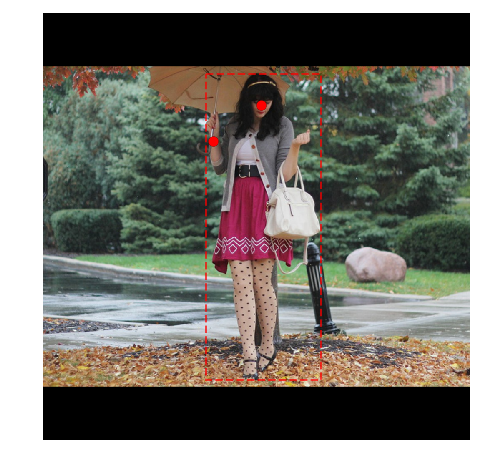

In [11]:
importlib.reload(visualize)

# Load a test image
image_id = dataset_val.image_ids[10]

# Get ground truth masks and bboxes
image, image_meta, gt_class_ids, gt_kp_ids, gt_bbox, gt_kp_masks = \
    modellib.load_image_gt(dataset_val, inference_config, image_id)

masks = []
for i in range(gt_kp_masks.shape[0]):
    msks = []
    for j in range(gt_kp_masks.shape[1]):
        mask = np.zeros((image.shape[:2]), dtype=np.bool)
        k = gt_kp_masks[i, j]
        mask[k // mask.shape[1], k % mask.shape[1]] = True
        msks.append(mask)
    masks.append(msks)
masks = np.array(masks)
    
log("image", image)
log("gt_class_ids", gt_class_ids)
log("gt_kp_ids", gt_kp_ids)
log("gt_bbox", gt_bbox)
log("gt_masks", gt_kp_masks)
log("masks", masks)

visualize.display_keypoints(image, gt_bbox, masks, gt_kp_ids,
                            #skeleton=dataset_train.skeleton,
                            figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
mrcnn_mask.shape (1, 100, 2, 28, 28)
mrcnn_mask.dtype float32
detections.shape (100, 6)
mrcnn_mask.shape (100, 2, 28, 28)
masks.shape (62, 2, 28, 28)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
class_ids                shape: (62,)                 min:    1.00000  max:    1.00000  int32
kp_ids                   shape: (12, 17)              min:    0.00000  max:   16.00000  int64
bbox                     shape: (62, 4)               min:    0.00000  max: 1024.00000  int32
masks                    shape: (62, 2, 1024, 1024)   min:    0.00000  max

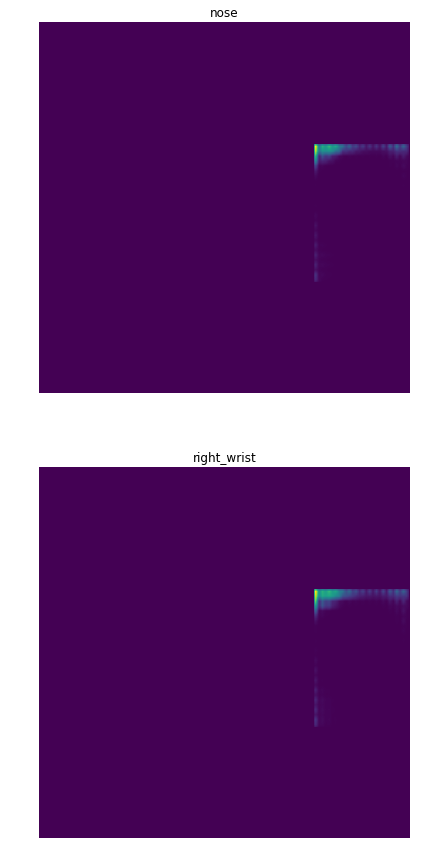

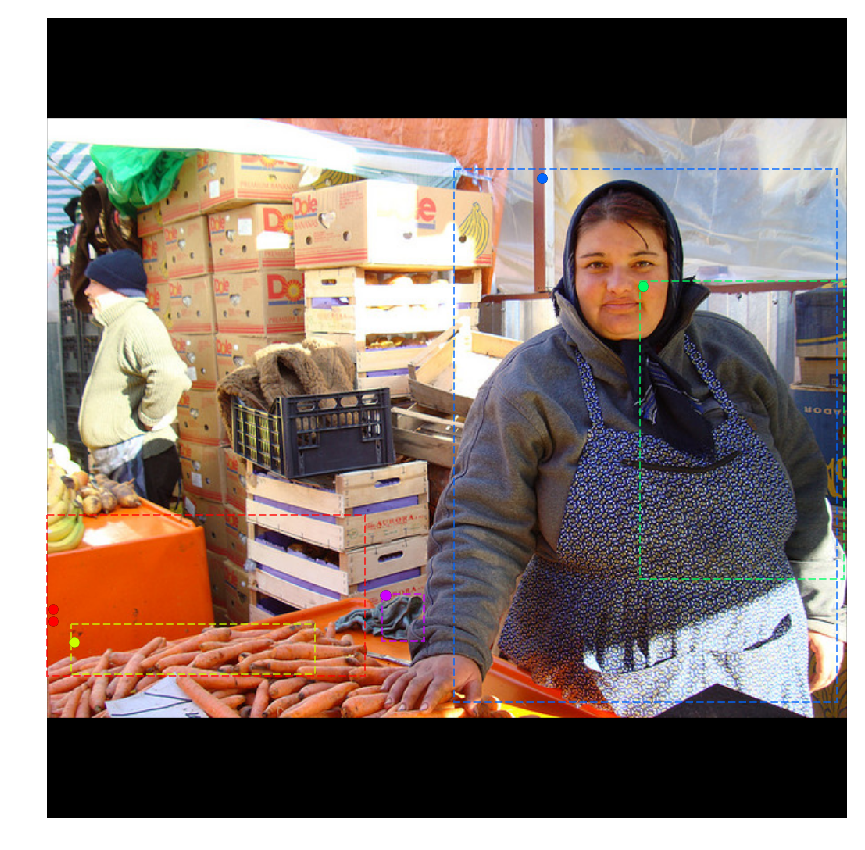

In [26]:
importlib.reload(modellib)

# Load a test image
image_id = np.random.choice(dataset_val.image_ids)

# Get ground truth masks and bboxes
image = modellib.load_image_gt(dataset_val, inference_config, image_id)[0]

results = model.detect([image], verbose=1)
r = results[0]

bbox, kp_masks, kp_ids = r["rois"], r["masks"], np.repeat(np.expand_dims(np.arange(17), axis=0), 12, axis=0)

log("image", image)
log("class_ids", r['class_ids'])
log("kp_ids", kp_ids)
log("bbox", bbox)
log("masks", kp_masks)

%matplotlib inline
import matplotlib.pyplot as plt

n = np.sqrt(inference_config.NUM_KEYPOINTS)
_, axes = plt.subplots(int(np.ceil(n)), int(np.floor(n)), figsize=(15, 15))
if n <= 1: axes = np.array(axes)
for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    if i >= inference_config.NUM_KEYPOINTS: continue
    #x, y = i % 4, i // 4
    
    ax.set_title(dataset_train.kp_class_names[i+1])
    ax.imshow(kp_masks[0, i])


plt.show()

visualize.display_keypoints(image, bbox[0:5], kp_masks[0:5],
                            #skeleton=dataset_train.skeleton
                            figsize=(15, 15))

In [12]:
print(r['class_ids'])
print(r["scores"])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0.79807985 0.78378683 0.77607787 0.77032447 0.77032185 0.7687765
 0.76452994 0.7605105  0.7550343  0.7541889  0.7516613  0.75108725
 0.7505772  0.7497083  0.7457354  0.7410921  0.7378156  0.7370233
 0.73693603 0.7340542  0.7336225  0.72915024 0.72880375 0.7276058
 0.7248023  0.7228959  0.7224429  0.7185769  0.71653724 0.7164517
 0.7153205  0.7144779  0.7144502  0.714258   0.71300036 0.71194255
 0.7100979  0.70978713 0.7095623  0.70893234 0.7083021  0.70828164
 0.7080848  0.70736414 0.70676535 0.7062619  0.7052838  0.70506465
 0.7044702  0.70339745 0.70320106 0.7031675  0.70150733 0.7013741
 0.6992929  0.6991737  0.69890445 0.69882387 0.6987664  0.69845486
 0.6975804  0.6974481  0.69723773 0.6963154  0.6950491  0.69493896
 0.6939821  0.6939662  0.69341135 0.6925788  0.6917796  0.691444

In [13]:
#visualize.display_keypoints(original_image, r['rois'], r['masks'], r['class_ids'],
#                            dataset_val.class_names, skeleton=None)

In [14]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
#print(det_class_ids)
#det_count = np.where(det_class_ids == 0)[0][0]
#det_class_ids = det_class_ids[:det_count]

#print("{} detections: {}".format(
#    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.02148  max:    1.00000  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    0.95545  float32


In [15]:
# Masks
"""det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)"""

'det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])\ndet_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] \n                              for i, c in enumerate(det_class_ids)])\ndet_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)\n                      for i, m in enumerate(det_mask_specific)])\nlog("det_mask_specific", det_mask_specific)\nlog("det_masks", det_masks)'

In [16]:
#visualize.display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")